# Summary
---

1. This notebook accompanies the report "The Application of Data Science to Mycovirus Mediated Hypovirulence"
     * https://docs.google.com/document/d/1LUwNmvYS5GuYBoMUKCzWVWVA7HZNeL-83lwadkfxcvM/edit?usp=sharing

All imports:

In [59]:
import pandas as pd
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

To run this notebook on your computer, adjust these path variables for the data location on your computer. This notebook depends on two fata files:
1. Sclerotinia_biocontrol_mycovirus_nucleotide.fasta
    - Assign PATH1 to this file
2. mycovirus_genbank_all_refseq_nucleotide_unique.fasta
    - Assign PATH01 to this file

In [60]:
PATH1 = "data/Sclerotinia_biocontrol_mycovirus_nucleotide.fasta"
PATH01 = "data/mycovirus_genbank_all_refseq_nucleotide_unique.fasta"

# Parsing And Embedding Data
-----

### Parsing Fasta Files

In [61]:
import pandas as pd
from Bio import SeqIO

In [62]:
def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])

    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

In [63]:
virus1 = parseFasta(PATH1)
virus1.head()

,Sequence
ID,
NC_007415.1,CTTTAGTAAATACCACCGCCTCTTAATAAGTCTCGAGGCACTCCCC...
NC_015939.1,GGGGTGATGGGAAACTTACGTTTCGCCAACGTTAAGGTACTGTGAT...
NC_022896.1,TTTTTGGGGATGGTACTCTCAGGTTTGATCTTTGTAGATCCTAACT...
NC_026510.1,TTGGCTCCTGGAGACCGTTAGGTCCCCAGAAGCGGTTCAATAGAAC...
NC_027138.1,GCAATAAAAAGCACAGCCGGAAGGCTTTCTTTTTATTGCCCAGTTT...


### Creating KMER Tables:

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
# kmer table with kmers of length a to b
# computes tf-idf
def kmerXTable(s, a, b):
    tfid_vector = TfidfVectorizer(analyzer='char', ngram_range=(a,b))
    s_hat = tfid_vector.fit_transform(s.Sequence)
    kmerNames = tfid_vector.get_feature_names()
    kmers = s_hat.toarray()
    return pd.DataFrame(kmers,columns=kmerNames, index = s.index)

In [66]:
kmer7Table1 = kmerXTable(virus1, 7,7)
kmer7Table1.head()

,aaaaaaa,aaaaaac,aaaaaag,aaaaaat,aaaaaca,aaaaacc,aaaaacg,aaaaact,aaaaaga,aaaaagc,...,tttttck,tttttct,tttttga,tttttgc,tttttgg,tttttgt,tttttta,ttttttc,ttttttg,ttttttt
ID,,,,,,,,,,,,,,,,,,,,,
NC_007415.1,0.413798,0.000000,0.0,0.000000,0.000000,0.009196,0.012391,0.018391,0.000000,0.00000,...,0.0,0.000000,0.018391,0.024782,0.000000,0.009196,0.000000,0.009196,0.024782,0.021183
NC_015939.1,0.219900,0.008231,0.0,0.014071,0.005351,0.000000,0.000000,0.012217,0.006108,0.00000,...,0.0,0.008231,0.000000,0.000000,0.012217,0.012217,0.007036,0.000000,0.000000,0.000000
NC_022896.1,0.120535,0.000000,0.0,0.000000,0.000000,0.009643,0.006497,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.014464,0.009643,0.005553,0.000000,0.006497,0.000000
NC_026510.1,0.000000,0.000000,0.0,0.000000,0.014261,0.000000,0.000000,0.000000,0.016280,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NC_027138.1,0.000000,0.000000,0.0,0.000000,0.007853,0.008964,0.000000,0.008964,0.000000,0.01208,...,0.0,0.000000,0.008964,0.012080,0.000000,0.000000,0.000000,0.008964,0.000000,0.000000


### Data Needed:

In [67]:
virus1 = parseFasta(PATH1)

# put confirmed virus killers at bottom, and removed the duplicates already in the data
virus01 = parseFasta(PATH01)
virus01 = virus01.append(virus1)
virus01 = virus01.drop_duplicates(keep="last")

# kmer of length 7 tf-idf tables
kmer7Table1 = kmerXTable(virus1, 7,7)
kmer7Table01 = kmerXTable(virus01, 7,7)

# labels for virus01
# -1 means unknown, 0 means fungus non-killer, 1 mean fungus killer
labels = [-1 for x in range(343)] + [1 for x in range(7)]

# Visualization
-----

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

In [69]:
def plot2D(show, title, xlabel, ylabel) :
    ax = show[show["labels"]==1].plot.scatter(x=0, y=1, style="o", color="red", s=2)
    show[show["labels"]==0].plot.scatter(x=0, y=1, style="o", color="blue", s=2, ax=ax)
    show[show["labels"]==-1].plot.scatter(x=0, y=1, style="o", color="gray", s=2, ax=ax)
    red = mpatches.Patch(color='red', label='Fungus Killers')
    blue = mpatches.Patch(color='blue', label='Fungus Non-Killers')
    gray = mpatches.Patch(color='gray', label='Unknown')
    plt.legend(handles=[red, blue, gray])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.savefig("report/" + title + ".png")
    plt.show()
    
def plot3D(show, title, xlabel, ylabel, zlabel):
    ax = plt.figure().gca(projection='3d')
    ax.scatter(show[show["labels"]==1][0], show[show["labels"]==1][1], show[show["labels"]==1][2], color="red")
    ax.scatter(show[show["labels"]==0][0], show[show["labels"]==0][1], show[show["labels"]==0][2], color="blue")
    ax.scatter(show[show["labels"]==-1][0], show[show["labels"]==-1][1], show[show["labels"]==-1][2], color="gray")
    red = mpatches.Patch(color='red', label='Fungus Killers')
    blue = mpatches.Patch(color='blue', label='Fungus Non-Killers')
    gray = mpatches.Patch(color='gray', label='Unknown')
    plt.legend(handles=[red, blue, gray])
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    # plt.savefig("report/" + title + ".png")
    plt.show()

In [70]:
# columns that confirmed virus killers have no zeros in for kmer length 7
# this resulted in the best visual seperation
cols = kmer7Table1.loc[:, (kmer7Table1 == 0).any(axis=0) != True].columns
cols

Index(['aaaacaa', 'aactttt', 'aagatga', 'aatcaaa', 'acaaata', 'agaagaa',
       'agatttc', 'aggaatt', 'aggagat', 'aggttga', 'atgtctg', 'atttgat',
       'caaaaac', 'caatata', 'caatttg', 'ccaaaaa', 'cttcaac', 'gaagata',
       'gaattcc', 'gagctga', 'gaggaat', 'ggaagat', 'gttgaag', 'tcaagaa',
       'tcaagga', 'tcacaag', 'tcttgga', 'tggaaag', 'tggaatt', 'ttcaaag',
       'ttctttc', 'ttgaaga', 'ttggaaa', 'ttttgat'],
      dtype='object')

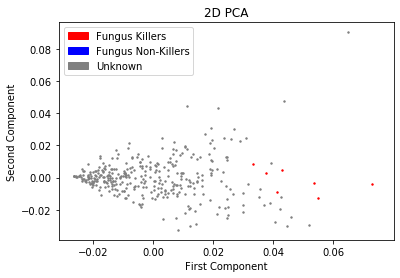

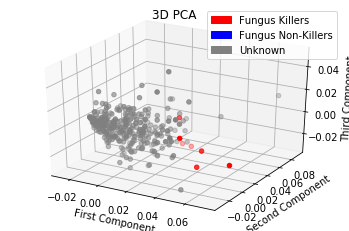

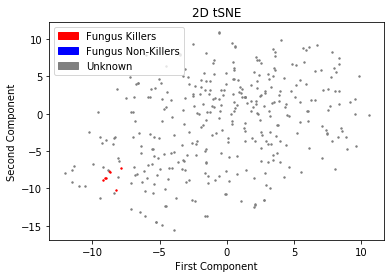

In [71]:
data = kmer7Table01[cols]

# fit and trasnform PCA
PCAembedding = PCA()
PCAembedding_low = PCAembedding.fit_transform(data)

# fit and trasnform tSNE
tSNEembedding = TSNE(2, random_state = 0)
tSNEembedding_low = tSNEembedding.fit_transform(data)

# PCA 2D graph
PCAshow = pd.DataFrame(PCAembedding_low)
PCAshow["labels"] = labels
plot2D(PCAshow, "2D PCA", "First Component", "Second Component")

# PCA 3D graph
plot3D(PCAshow, "3D PCA", "First Component", "Second Component", "Third Component")

# tSNE 2D graph
tSNEshow = pd.DataFrame(tSNEembedding_low)
tSNEshow["labels"] = labels
plot2D(tSNEshow, "2D tSNE", "First Component", "Second Component")

# K-Means and Mean Shift
-----

### K-means:

In [72]:
from sklearn.cluster import KMeans

In [73]:
# K-means with two clusters
km = KMeans(2, random_state = 42)
km.fit(data)

km_labels = km.predict(data)

### K-means with Mean Shift:

In [74]:
from sklearn.cluster import MeanShift
import numpy as np

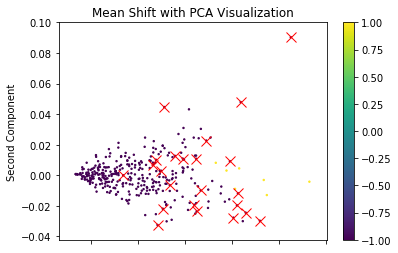

In [75]:
# Mean Shift on data
ms = MeanShift()
ms.fit(PCAshow.loc[:, PCAshow.columns != "labels"])
cluster_centers = ms.cluster_centers_
ax = PCAshow.plot.scatter(x=0, y=1, style="o", c=labels, cmap = "viridis", s=2)
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', color='red', s=100, linewidth=1)
plt.title('Mean Shift with PCA Visualization')
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.show()

In [76]:
# set k-means initial cluster centers to the mean shift cluster centers

cluster_centers = PCAembedding.inverse_transform(ms.cluster_centers_)
# Same as 
# ms.fit(data)
# cluster_centers = ms.cluster_centers_

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kmms = KMeans(init = cluster_centers, n_clusters = len(cluster_centers))
    kmms.fit(data)
kmms_labels = kmms.predict(data)

# convert all clusters into two clusters
newLabels_clusters = kmms_labels[343:]
newLabels = []

for label in kmms_labels:
    if label in newLabels_clusters:
        newLabels.append(1)
    else:
        newLabels.append(0)

### Results:

In [77]:
# original kmeans labels
#print(np.array(km_labels))
print("K-means sum of fungus-killers: ", sum(km_labels))

# kmeans with mean shift labels
#print(np.array(newLabels))
print("K-means with mean shift sum of fungus-killers: ", sum(newLabels))

K-means sum of fungus-killers:  131
K-means with mean shift sum of fungus-killers:  35


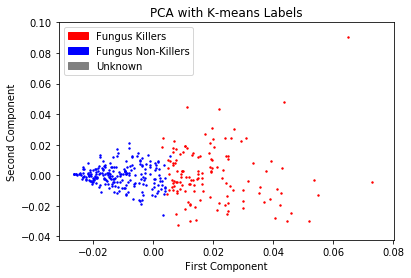

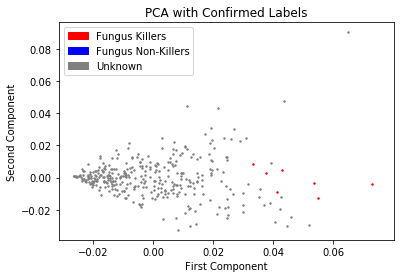

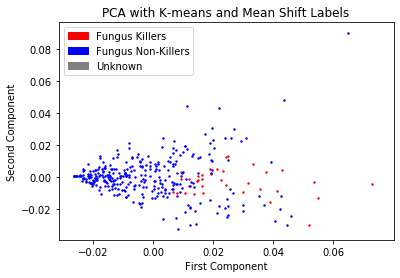

In [78]:
PCAshow["labels"] = km_labels
plot2D(PCAshow, "PCA with K-means Labels", "First Component", "Second Component")

PCAshow["labels"] = labels
plot2D(PCAshow, "PCA with Confirmed Labels", "First Component", "Second Component")

PCAshow["labels"] = newLabels
plot2D(PCAshow, "PCA with K-means and Mean Shift Labels", "First Component", "Second Component")

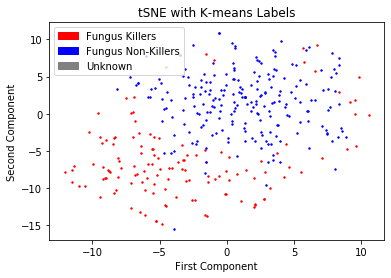

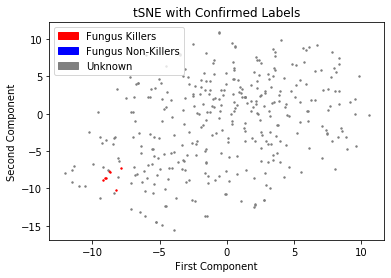

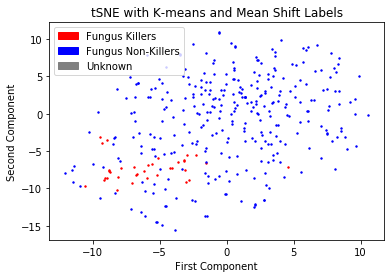

In [79]:
tSNEshow["labels"] = km_labels
plot2D(tSNEshow, "tSNE with K-means Labels", "First Component", "Second Component")

tSNEshow["labels"] = labels
plot2D(tSNEshow, "tSNE with Confirmed Labels", "First Component", "Second Component")

tSNEshow["labels"] = newLabels
plot2D(tSNEshow, "tSNE with K-means and Mean Shift Labels", "First Component", "Second Component")

# Output
-----
The tables are shortned in order to not take up too much space, with n within .head(n=10) representing the number of rows to print

In [80]:
virus1["Kmeans and Meanshift labels"] = newLabels[343:]
virus1["Kmeans labels"] = km_labels[343:]
virus1["Confirmed labels"] = labels[343:]

virus01["Kmeans and Meanshift labels"] = newLabels
virus01["Kmeans labels"] = km_labels
virus01["Confirmed labels"] = labels

In [81]:
virus1.head(n=10)

,Sequence,Kmeans and Meanshift labels,Kmeans labels,Confirmed labels
ID,,,,
NC_007415.1,CTTTAGTAAATACCACCGCCTCTTAATAAGTCTCGAGGCACTCCCC...,1,1,1
NC_015939.1,GGGGTGATGGGAAACTTACGTTTCGCCAACGTTAAGGTACTGTGAT...,1,1,1
NC_022896.1,TTTTTGGGGATGGTACTCTCAGGTTTGATCTTTGTAGATCCTAACT...,1,1,1
NC_026510.1,TTGGCTCCTGGAGACCGTTAGGTCCCCAGAAGCGGTTCAATAGAAC...,1,1,1
NC_027138.1,GCAATAAAAAGCACAGCCGGAAGGCTTTCTTTTTATTGCCCAGTTT...,1,1,1
NC_027139.1,GCAATAAAAAGCACAGCCGGAAGGCTTTCTTTTTATTGCCCAGTTT...,1,1,1
NC_025383.1,AGGGAGTATTATAATTACCTTCGTAGTTGTTCTTACTCTCTGGTAC...,1,1,1


In [82]:
virus01.head(n=10)

,Sequence,Kmeans and Meanshift labels,Kmeans labels,Confirmed labels
ID,,,,
NC_000960.1,GGGGGTTAGAGAAATCTTGGGAGATTTCTATCGTCATAGACATATG...,1,1,-1
NC_001278.1,GGGAAATTTGTGAGATTATCGCCCTAAAGGATAACTCTCATGCGGG...,0,0,-1
NC_001492.1,GCCTATGGGTGGTCTACATAGGTGAGCATGCGTTGCTCGATATAGA...,0,1,-1
NC_001633.1,ACAAAATAATTGAAGAAATTATTTTTGTTTTACATATTTAGATCTT...,0,1,-1
NC_001641.1,GAATTTTTCGGTGAACCGGAATTATGTCGTCTCTGTTAAATTCATT...,0,0,-1
NC_001782.1,GAAAAATAAAGAAATGACGAAGCCAACCCAAGTATTAGTTAGATCC...,0,0,-1
NC_001963.1,GGATTTCACGTACAACGTAGGGTTGTCCTTACGCGTTGCGCGCAAG...,0,0,-1
NC_001964.1,CCAGGGACCCCTGCAGCCCCCTGTTTGTCAGCGCCTGTAATAGGGT...,0,0,-1
NC_002604.1,GATTAAATTCACATCCAACAGACACAGACACCAAACACCAAACGCC...,0,0,-1


In [83]:
print("Confirmed Labels:")
print(labels)
print("K-means Labels:")
print(km_labels)
print("K-means and Mean Shift Labels:")
print(newLabels)

Confirmed Labels:
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

# Remarks
-----
1. Python script: https://github.com/solislemuslab/mycovirus-ml/blob/master/scripts/lukeSelberg/nonNotebookFiles/websiteScriptKmeans.py
     * This script is still under development, but contains a python script allowing these algorthims to be applied to new data
2. Comparision notebook: https://github.com/solislemuslab/mycovirus-ml/blob/master/scripts/lukeSelberg/modelComparison.ipynb
     * This notebook compares my models to the models of other members of this team